Retail Demand Forecasting Notebook 

In [1]:
#1. Load and Clean Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('retail_merged_data.csv', parse_dates=['Time stamp'])

# Lowercase & clean column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Drop NAs in critical columns
df = df.dropna(subset=['purchase_amount_(usd)', 'time_stamp'])

# For simplicity, focus on time series
df = df[['time_stamp', 'purchase_amount_(usd)']]
df = df.rename(columns={'purchase_amount_(usd)': 'purchase_amount_usd'})

# Preview
print(df.head())


        time_stamp  purchase_amount_usd
0  10/10/2023 8:00                 53.0
1  11/10/2023 8:00                 64.0
2  12/10/2023 8:00                 73.0
3  13/10/2023 8:00                 90.0
4  14/10/2023 8:00                 49.0


In [5]:
import pandas as pd

df = pd.read_csv('retail_merged_data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['time_stamp'] = pd.to_datetime(df['time_stamp'], errors='coerce')
df = df.dropna(subset=['purchase_amount_(usd)', 'time_stamp'])
df = df[['time_stamp', 'purchase_amount_(usd)']]
df = df.rename(columns={'purchase_amount_(usd)': 'purchase_amount_usd'})


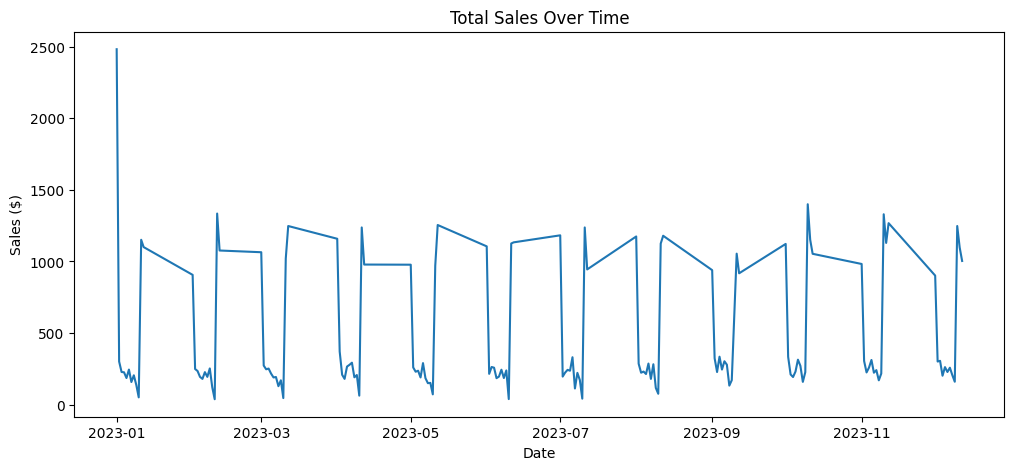

In [6]:
df['date_only'] = df['time_stamp'].dt.date
daily_sales = df.groupby('date_only')['purchase_amount_usd'].sum().reset_index()
daily_sales['date_only'] = pd.to_datetime(daily_sales['date_only'])

plt.figure(figsize=(12,5))
plt.plot(daily_sales['date_only'], daily_sales['purchase_amount_usd'])
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.show()


In [7]:
#Fill Missing Dates

all_days = pd.date_range(daily_sales['date_only'].min(), daily_sales['date_only'].max(), freq='D')
daily_sales = daily_sales.set_index('date_only').reindex(all_days)
daily_sales.index.name = 'date_only'
daily_sales['purchase_amount_usd'] = daily_sales['purchase_amount_usd'].fillna(0)
daily_sales = daily_sales.reset_index()


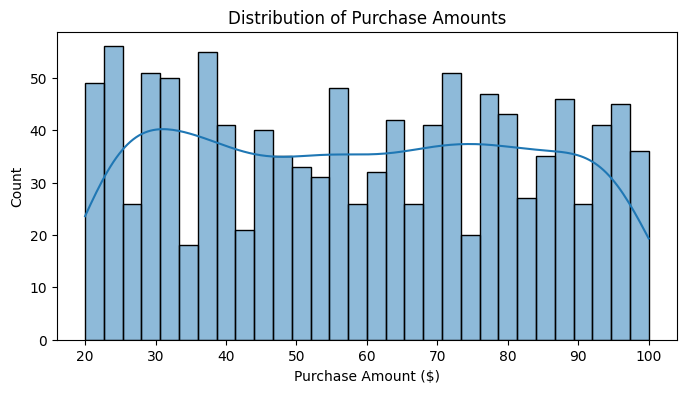

In [8]:
#EDA
#Distribution of Purchase Amounts:

plt.figure(figsize=(8,4))
sns.histplot(df['purchase_amount_usd'], bins=30, kde=True)
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Purchase Amount ($)')
plt.show()



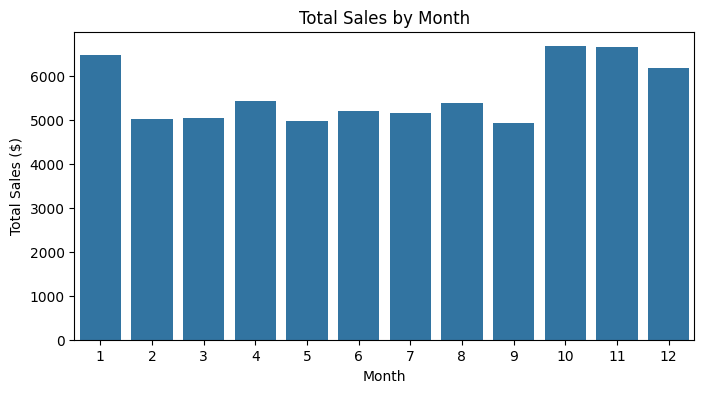

In [10]:
#Monthly Sales:

# Group and sum only the numeric column(s)
monthly_sales = daily_sales.groupby('month', as_index=False)['purchase_amount_usd'].sum()

plt.figure(figsize=(8,4))
sns.barplot(x='month', y='purchase_amount_usd', data=monthly_sales)
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.show()


In [11]:
# Feature Engineering 

ds = daily_sales.copy()
ds['day_of_week'] = ds['date_only'].dt.dayofweek
ds['weekofyear'] = ds['date_only'].dt.isocalendar().week
ds['is_weekend'] = (ds['day_of_week'] >= 5).astype(int)
ds['is_month_end'] = ds['date_only'].dt.is_month_end.astype(int)
ds['year'] = ds['date_only'].dt.year

# Lag & rolling features
ds['sales_lag_1'] = ds['purchase_amount_usd'].shift(1)
ds['sales_lag_7'] = ds['purchase_amount_usd'].shift(7)
ds['rolling_7d_mean'] = ds['purchase_amount_usd'].rolling(7).mean()

# Drop NA from lags
model_df = ds.dropna()


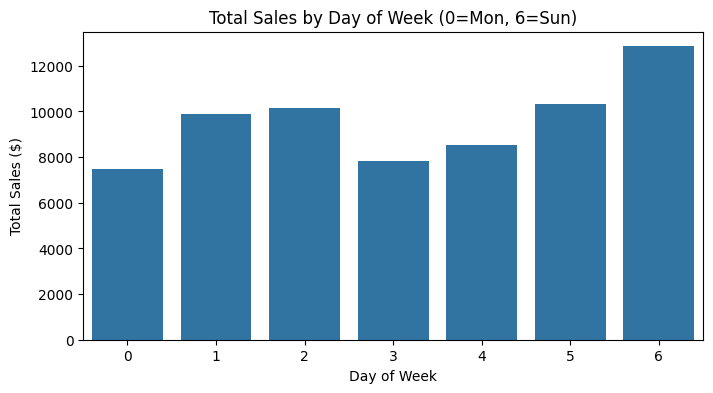

In [13]:
#Visualize: Weekly Seasonality

# Group and sum only the numeric column(s)
dow_sales = ds.groupby('day_of_week', as_index=False)['purchase_amount_usd'].sum()

plt.figure(figsize=(8,4))
sns.barplot(x='day_of_week', y='purchase_amount_usd', data=dow_sales)
plt.title('Total Sales by Day of Week (0=Mon, 6=Sun)')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales ($)')
plt.show()



In [14]:
#Train/Test Split for Modeling

split = int(len(model_df)*0.8)
train, test = model_df.iloc[:split], model_df.iloc[split:]

feature_cols = ['sales_lag_1','sales_lag_7','rolling_7d_mean','month','day_of_week','weekofyear','is_weekend','is_month_end','year']
X_train, X_test = train[feature_cols], test[feature_cols]
y_train, y_test = train['purchase_amount_usd'], test['purchase_amount_usd']


XGBoost Test RMSE: 417.45448298307116
XGBoost Test MAE: 201.31220041303072


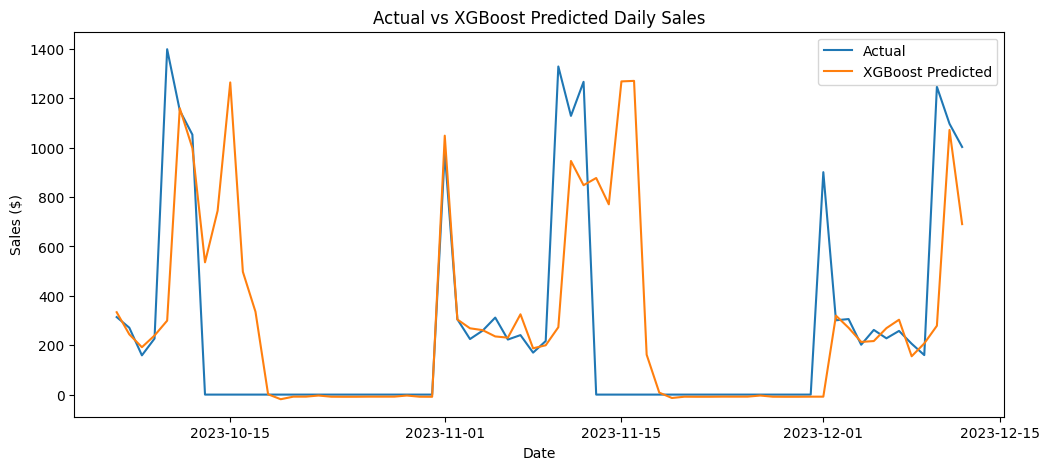

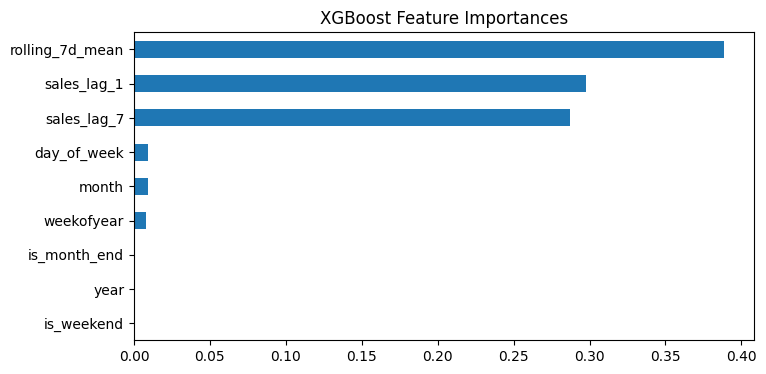

In [16]:
#XGBoost Model & Visual Evaluation

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("XGBoost Test RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))
print("XGBoost Test MAE:", mean_absolute_error(y_test, xgb_pred))

plt.figure(figsize=(12,5))
plt.plot(test['date_only'], y_test, label='Actual')
plt.plot(test['date_only'], xgb_pred, label='XGBoost Predicted')
plt.title('Actual vs XGBoost Predicted Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.show()

# Feature importance plot
feat_imp = pd.Series(xgb.feature_importances_, index=feature_cols)
feat_imp.sort_values().plot(kind='barh', figsize=(8,4), title="XGBoost Feature Importances")
plt.show()


C:\Users\nikhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Test RMSE: 417.41654616958726
ARIMA Test MAE: 271.04537346593406


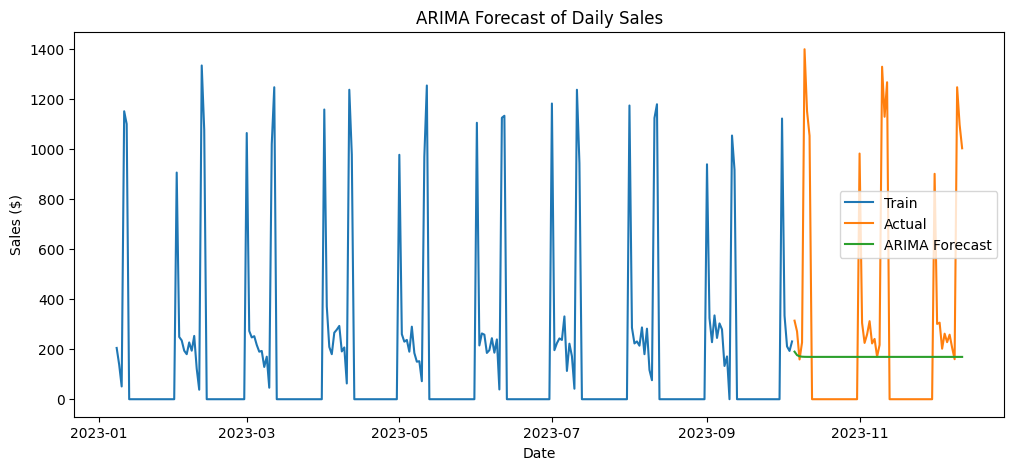

In [18]:
#ARIMA Model & Visual Evaluation

from statsmodels.tsa.arima.model import ARIMA

# Use all training data for ARIMA
arima_series = train.set_index('date_only')['purchase_amount_usd']

# Fit ARIMA (simple example, tune order as needed)
model = ARIMA(arima_series, order=(1,1,1))
arima_fit = model.fit()

# Forecast for test period
forecast = arima_fit.forecast(steps=len(test))
forecast = pd.Series(forecast.values, index=test['date_only'])

print("ARIMA Test RMSE:", np.sqrt(mean_squared_error(y_test, forecast)))
print("ARIMA Test MAE:", mean_absolute_error(y_test, forecast))

plt.figure(figsize=(12,5))
plt.plot(train['date_only'], y_train, label='Train')
plt.plot(test['date_only'], y_test, label='Actual')
plt.plot(test['date_only'], forecast, label='ARIMA Forecast')
plt.title('ARIMA Forecast of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.show()


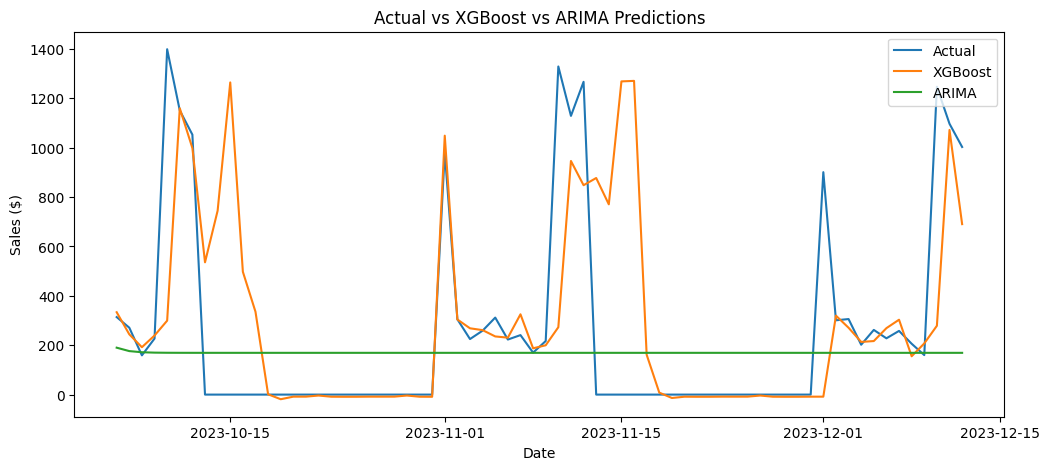

In [19]:
#Comparing XGBoost vs ARIMA

plt.figure(figsize=(12,5))
plt.plot(test['date_only'], y_test, label='Actual')
plt.plot(test['date_only'], xgb_pred, label='XGBoost')
plt.plot(test['date_only'], forecast, label='ARIMA')
plt.title('Actual vs XGBoost vs ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.show()
